In [26]:
import pandas as pd
import numpy as np

In [27]:
df = pd.read_csv("../data/nifty_regime_5min.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18656 entries, 0 to 18655
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             18656 non-null  datetime64[ns]
 1   spot_open            18656 non-null  float64       
 2   spot_high            18656 non-null  float64       
 3   spot_low             18656 non-null  float64       
 4   spot_close           18656 non-null  float64       
 5   spot_volume          18656 non-null  int64         
 6   fut_open             18656 non-null  float64       
 7   fut_high             18656 non-null  float64       
 8   fut_low              18656 non-null  float64       
 9   fut_close            18656 non-null  float64       
 10  fut_volume           18656 non-null  int64         
 11  opt_open             18656 non-null  float64       
 12  opt_high             18656 non-null  float64       
 13  opt_low              18656 non-

In [28]:
regime_trade_map = {
    "Trending": 1,
    "Range": 0,
    "Volatile": 0
}

df["regime_trade_allowed"] = df["regime_label"].map(regime_trade_map)

df[["regime_label", "regime_trade_allowed"]].head()



,regime_label,regime_trade_allowed
0,Volatile,0
1,Volatile,0
2,Volatile,0
3,Volatile,0
4,Volatile,0


In [29]:
# Calculate Slower EMAs for Logic
df["ema_20"] = df["spot_close"].ewm(span=20, adjust=False).mean()
df["ema_50"] = df["spot_close"].ewm(span=50, adjust=False).mean()

# Signal: EMA 20 > EMA 50
df["ema_signal"] = np.where(df["ema_20"] > df["ema_50"], 1, -1)

In [30]:
df["trade_signal"] = df["ema_signal"] * df["regime_trade_allowed"]


In [31]:
df["trade_entry"] = df["trade_signal"].diff()

In [32]:
df["trade_exit"] = (
    (df["trade_signal"] == 0) |
    (df["ema_signal"].diff() != 0)
)

In [33]:
df["trade_signal"].value_counts()

trade_signal
 0    18388
-1      216
 1       52
Name: count, dtype: int64

In [34]:
df.to_csv("../data/nifty_strategy_signals.csv" , index=False)

In [35]:
split_idx = int(len(df) * 0.7)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

print("Train size:", len(train_df))
print("Test size :", len(test_df))


Train size: 13059
Test size : 5597


In [36]:
test_df["market_return"] = test_df["spot_close"].pct_change()

# Use lagged signal to avoid look-ahead bias
test_df["strategy_return"] = (
    test_df["trade_signal"].shift(1) * test_df["market_return"]
)

test_df = test_df.dropna()


In [37]:
test_df["cum_market_return"] = (1 + test_df["market_return"]).cumprod()
test_df["cum_strategy_return"] = (1 + test_df["strategy_return"]).cumprod()


In [38]:
total_strategy_return = test_df["cum_strategy_return"].iloc[-1] - 1
total_market_return   = test_df["cum_market_return"].iloc[-1] - 1

print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Total Market Return  : {total_market_return:.2%}")


Total Strategy Return: -1.77%
Total Market Return  : -23.72%


In [39]:
annual_factor = np.sqrt(252 * 78)  # 5-min candles

sharpe_ratio = (
    test_df["strategy_return"].mean()
    / test_df["strategy_return"].std()
) * annual_factor

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: -1.38


In [40]:
downside_returns = test_df.loc[
    test_df["strategy_return"] < 0, "strategy_return"
]

sortino_ratio = (
    test_df["strategy_return"].mean()
    / downside_returns.std()
) * annual_factor

print(f"Sortino Ratio: {sortino_ratio:.2f}")


Sortino Ratio: -0.23


In [41]:
cum_returns = test_df["cum_strategy_return"]
rolling_max = cum_returns.cummax()

drawdown = (cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"Max Drawdown: {max_drawdown:.2%}")


Max Drawdown: -2.94%


In [42]:
calmar_ratio = total_strategy_return / abs(max_drawdown)

print(f"Calmar Ratio: {calmar_ratio:.2f}")


Calmar Ratio: -0.60


In [43]:
test_df["trade_change"] = test_df["trade_signal"].diff()

entries = test_df[test_df["trade_change"] != 0]
total_trades = len(entries)

print("Total Trades:", total_trades)


Total Trades: 30


In [44]:
trade_returns = test_df.groupby(
    (test_df["trade_change"] != 0).cumsum()
)["strategy_return"].sum()

winning_trades = trade_returns[trade_returns > 0]
losing_trades  = trade_returns[trade_returns < 0]

win_rate = len(winning_trades) / len(trade_returns)
profit_factor = winning_trades.sum() / abs(losing_trades.sum())

print(f"Win Rate: {win_rate:.2%}")
print(f"Profit Factor: {profit_factor:.2f}")


Win Rate: 40.00%
Profit Factor: 0.69


In [45]:
trade_durations = test_df.groupby(
    (test_df["trade_change"] != 0).cumsum()
).size()

avg_trade_duration = trade_durations.mean()

print(f"Average Trade Duration (bars): {avg_trade_duration:.2f}")


Average Trade Duration (bars): 186.53


In [46]:
performance_summary = pd.DataFrame({
    "Metric": [
        "Total Return",
        "Sharpe Ratio",
        "Sortino Ratio",
        "Calmar Ratio",
        "Max Drawdown",
        "Win Rate",
        "Profit Factor",
        "Average Trade Duration",
        "Total Trades"
    ],
    "Value": [
        f"{total_strategy_return:.2%}",
        f"{sharpe_ratio:.2f}",
        f"{sortino_ratio:.2f}",
        f"{calmar_ratio:.2f}",
        f"{max_drawdown:.2%}",
        f"{win_rate:.2%}",
        f"{profit_factor:.2f}",
        f"{avg_trade_duration:.2f}",
        total_trades
    ]
})

performance_summary


,Metric,Value
0,Total Return,-1.77%
1,Sharpe Ratio,-1.38
2,Sortino Ratio,-0.23
3,Calmar Ratio,-0.60
4,Max Drawdown,-2.94%
5,Win Rate,40.00%
6,Profit Factor,0.69
7,Average Trade Duration,186.53
8,Total Trades,30


In [47]:
test_df.to_csv("../results/nifty_backtest_test_results.csv", index=False)
performance_summary.to_csv("../results/nifty_backtest_metrics.csv", index=False)


In [48]:
# Strategy return per bar
test_df["strategy_return"] = test_df["trade_signal"].shift(1) * test_df["spot_return"]

# Cumulative strategy return
test_df["cum_strategy_return"] = (1 + test_df["strategy_return"]).cumprod() - 1

# Market benchmark
test_df["market_return"] = test_df["spot_return"]
test_df["cum_market_return"] = (1 + test_df["market_return"]).cumprod() - 1


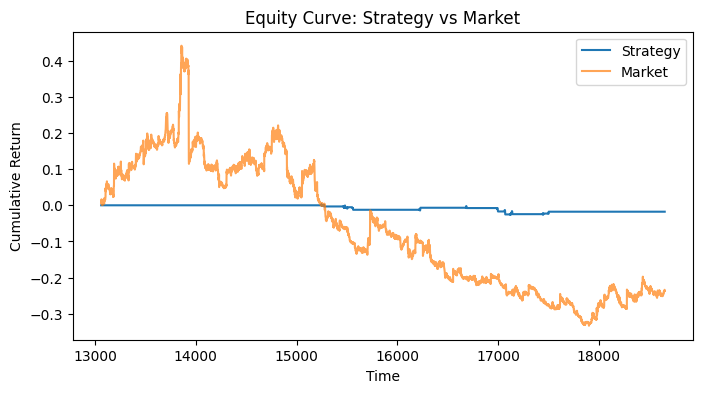

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(test_df["cum_strategy_return"], label="Strategy")
plt.plot(test_df["cum_market_return"], label="Market", alpha=0.7)
plt.legend()

plt.title("Equity Curve: Strategy vs Market")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")

plt.savefig("../plots/equity_curve.png", dpi=150, bbox_inches="tight")
plt.show()
